<a href="https://colab.research.google.com/github/tanya1280mishra/studious-umbrella/blob/main/Example_on_BRATS2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extract the Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# 1. Install Kaggle API
!pip install kaggle

# 2. Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload the kaggle.json file when prompted

# 3. Create Kaggle directory and move the API key file
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json  # Rename and move the file
!chmod 600 ~/.kaggle/kaggle.json  # Set correct permissions

# 4. Download the dataset
!kaggle datasets download -d harshitsinghai/miccai-brats2018-original-dataset

# 5. Unzip the dataset
!unzip miccai-brats2018-original-dataset.zip -d ./brats_dataset

# 6. Verify files
import os
print("Files in dataset directory:", os.listdir("./brats_dataset"))

Saving kaggle (1).json to kaggle (1) (1).json
Dataset URL: https://www.kaggle.com/datasets/harshitsinghai/miccai-brats2018-original-dataset
License(s): unknown
Archive:  miccai-brats2018-original-dataset.zip
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii  
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_seg.nii  
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1.nii  
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t1ce.nii  
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_t2.nii  
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_flair.nii  
  inflating: ./brats_dataset/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii  
  inflating:

In [10]:
# import zipfile  # For faster extraction
# dataset_path = "/gdrive/My Drive/MICCAI_BraTS_2018_Data_Training.zip"  # Replace with your dataset path
# zfile = zipfile.ZipFile(dataset_path)
# zfile.extractall()

## Get required packages
- **SimpleITK**: For loading the dataset
- **[model.py](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/)**: The model from BRATS2018 winning paper

In [11]:
!pip install simpleitk
!wget https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 22.6 MB/s eta 0:00:00
--2025-03-31 12:13:56--  https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/raw/master/model.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/master/model.py [following]
--2025-03-31 12:13:57--  https://raw.githubusercontent.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/master/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16490 (16K) [text/pl

## Imports and helper functions

In [13]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
# from model import build_model  # For creating the model
from tensorflow.keras.losses import MeanSquaredError  # Correct import
import glob  # For populating the list of files
from scipy.ndimage import zoom  # For resizing
import re  # For parsing the filenames (to know their modality)

In [14]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

In [15]:
def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1],
        shape[2]/orig_shape[2]
    )

    # Resize to the given shape
    return zoom(img, factors, mode=mode)


def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')

    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET — label 1)
    """
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)

    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)


## Loading Data


In [25]:
# Get a list of files for all modalities individually
t1 = glob.glob('*GG/*/*t1.nii')
t2 = glob.glob('*GG/*/*t2.nii')
flair = glob.glob('*GG/*/*flair.nii')
t1ce = glob.glob('*GG/*/*t1ce.nii')
seg = glob.glob('*GG/*/*seg.nii')  # Ground Truth

Parse all the filenames and create a dictionary for each patient with structure:

{<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1': _<path to t1 MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t2': _<path to t2 MRI&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'flair': _<path to FLAIR MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'t1ce': _<path to t1ce MRI file&gt;_,<br />
    &nbsp;&nbsp;&nbsp;&nbsp;'seg': _<path to Ground Truth file&gt;_,<br />
}<br />

In [27]:
t1

[]

In [17]:
pat = re.compile('.*_(\w*)\.nii\.gz')

data_paths = [{
    pat.findall(item)[0]:item
    for item in items
}
for items in list(zip(t1, t2, t1ce, flair, seg))]

## Load the data in a Numpy array
Creating an empty Numpy array beforehand and then filling up the data helps you gauge beforehand if the data fits in your memory.



_Loading only the first 4 images here, to save time._

In [18]:
input_shape = (4, 80, 96, 64)
output_channels = 3
data = np.empty((len(data_paths[:4]),) + input_shape, dtype=np.float32)
labels = np.empty((len(data_paths[:4]), output_channels) + input_shape[1:], dtype=np.uint8)

In [19]:
import math

# Parameters for the progress bar
total = len(data_paths[:4])
step = 25 / total

for i, imgs in enumerate(data_paths[:4]):
    try:
        data[i] = np.array([preprocess(read_img(imgs[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
        labels[i] = preprocess_label(read_img(imgs['seg']), input_shape[1:])[None, ...]

        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

ZeroDivisionError: division by zero

## Model

build the model

In [ ]:
model = build_model(input_shape=input_shape, output_channels=3)

Train the model

In [ ]:
model.fit(data, [labels, data], batch_size=1, epochs=1)

Epoch 1/1
4/4 [==============================] - 29s 7s/step - loss: 0.3766 - acc: 0.1188


That's it!

## Closing Regards

If you are resizing the segmentation mask, the resized segmentation mask retains the overall shape, but loses a lot of pixels and becomes somewhat 'grainy'. See the illustration below.

1. Original segmentation mask:

(240, 240)
[0 1]
2111


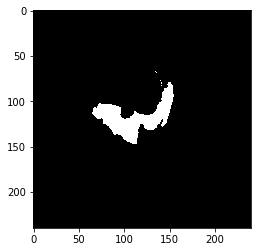

In [ ]:
import matplotlib.pyplot as plt
img = (read_img(seg[0])[100] == 2).astype(np.uint8)
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

After resizing to (80, 96, 64)

(96, 64)
[0 1]
116


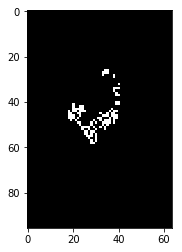

In [ ]:
img = preprocess_label(read_img(seg[0]), out_shape=(80, 96, 64), mode='nearest')[1][50]
print(img.shape)
print(np.unique(img))
print(img.sum())
plt.imshow(img, cmap='Greys_r')

One can clearly notice that there are now a lot of black pixels in the region where there should have been only white pixels. This can potentially hurt our model. So, it is best to not resize the image too much. But, due to computational constraints and the model requirements, it is unavoidable.

However, given below are a few things one could try to reduce the downsampling noise as much as possible.

In [ ]:
import cv2

- Original Image > preprocess_label > Morphological Closing

[0 1]
491


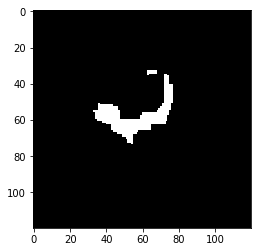

In [ ]:
kernel = np.ones((3, 3))
img_closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
print(np.unique(img_closed))
print(img_closed.sum())
plt.imshow(img_closed, cmap='Greys_r')

- Original Image > preprocess_label > Morphological Dilation

[0 1]
660


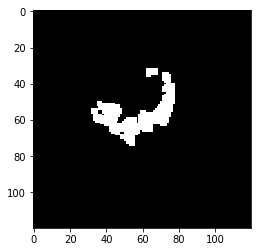

In [ ]:
kernel = np.ones((3, 3))
img_dilated = cv2.dilate(img, kernel, iterations=1)
print(np.unique(img_dilated))
print(img_dilated.sum())
plt.imshow(img_dilated, cmap='Greys_r')

You could try these things to get even better results.

## Feedback

If you have any feedback, queries, bug reports to send, please feel free to [raise an issue](https://github.com/IAmSuyogJadhav/3d-mri-brain-tumor-segmentation-using-autoencoder-regularization/issues/new) on github. It would be really helpful!